In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

C:\Users\91989\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pwd

'C:\\Users\\91989\\Documents\\project'

In [3]:
os.listdir(".//")

['.ipynb_checkpoints',
 '40x40_Projection.npy',
 '40x40_Raw.npy',
 'Cloud.ipynb',
 'dataset',
 'project_final.ipynb',
 'test.csv',
 'train.csv',
 'Untitled.ipynb']

In [4]:
def seq(x,y,steps,t):
    ar = []
    for i in range(t):
        ar.append(x[i:i+steps])
    return torch.stack(ar),y[:t]

In [5]:
mn = {'Total Cloud Cover [%]':0}
std = {'Total Cloud Cover [%]':100}
ar = []

#Train
df = pd.read_csv('./dataset/train/train.csv')

for i in range(len(df)):
    if df.at[i,'Total Cloud Cover [%]'] == -7999:
        pr = (df.at[i-1,'Total Cloud Cover [%]']+df.at[i+3,'Total Cloud Cover [%]'])/2
        df.at[i,'Total Cloud Cover [%]'] = pr
        df.at[i+1,'Total Cloud Cover [%]'] = pr
        df.at[i+2,'Total Cloud Cover [%]'] = pr
df = df[df['Total Cloud Cover [%]'] >=0]
df = df.drop(['MST'],1)

for c in df.columns:
    if c == "DATE (MM/DD)" or c == 'Total Cloud Cover [%]':
        continue  
    std[c] = np.std(df[c].values)
    if std[c] == 0:
        std[c] = 1
    mn[c] = np.mean(df[c].values)
        
for i in df['DATE (MM/DD)'].unique():
  ar.append(df[df['DATE (MM/DD)']==i].drop('DATE (MM/DD)',1).apply(lambda x: (x-mn[x.name])/std[x.name]))

df = df.drop('DATE (MM/DD)',1).apply(lambda x: (x-mn[x.name])/std[x.name])
#515

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252254 entries, 467 to 526585
Data columns (total 15 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Global CMP22 (vent/cor) [W/m^2]        252254 non-null  float64
 1   Direct sNIP [W/m^2]                    252254 non-null  float64
 2   Azimuth Angle [degrees]                252254 non-null  float64
 3   Tower Dry Bulb Temp [deg C]            252254 non-null  float64
 4   Tower Wet Bulb Temp [deg C]            252254 non-null  float64
 5   Tower Dew Point Temp [deg C]           252254 non-null  float64
 6   Tower RH [%]                           252254 non-null  float64
 7   Total Cloud Cover [%]                  252254 non-null  float64
 8   Peak Wind Speed @ 6ft [m/s]            252254 non-null  float64
 9   Avg Wind Direction @ 6ft [deg from N]  252254 non-null  float64
 10  Station Pressure [mBar]                252254 non-null

In [7]:
#Test
directory = "./dataset/test"

testar = [0]*300
for root, subdirectories, files in os.walk(directory):
    for subdirectory in subdirectories:
        dt = pd.read_csv(os.path.join(os.path.join(root, subdirectory),'weather_data.csv'))
        dt = dt[dt['Total Cloud Cover [%]'] >=0]
        dt = dt.drop(['Time [Mins]'],1)
        dt = dt.apply(lambda x: (x-mn[x.name])/std[x.name])
        testar[int(subdirectory)-1] = dt

In [8]:
for c in ar[0].columns:
  print(c,np.std(ar[0][c].values))
print(ar[0].shape)

Global CMP22 (vent/cor) [W/m^2] 0.4341739592988277
Direct sNIP [W/m^2] 0.9653758424496791
Azimuth Angle [degrees] 0.5421536477622304
Tower Dry Bulb Temp [deg C] 0.11302224608571786
Tower Wet Bulb Temp [deg C] 0.12713702376087954
Tower Dew Point Temp [deg C] 0.22564908178098356
Tower RH [%] 0.21412628087223115
Total Cloud Cover [%] 0.37620529235874706
Peak Wind Speed @ 6ft [m/s] 1.178111997836059
Avg Wind Direction @ 6ft [deg from N] 0.8349360637541855
Station Pressure [mBar] 0.08516568170353621
Precipitation (Accumulated) [mm] 2.7755575615628914e-17
Snow Depth [cm] 0.0006454745464651726
Moisture 5.551115123125783e-17
Albedo (CMP11) 0.19184212815293575
(519, 15)


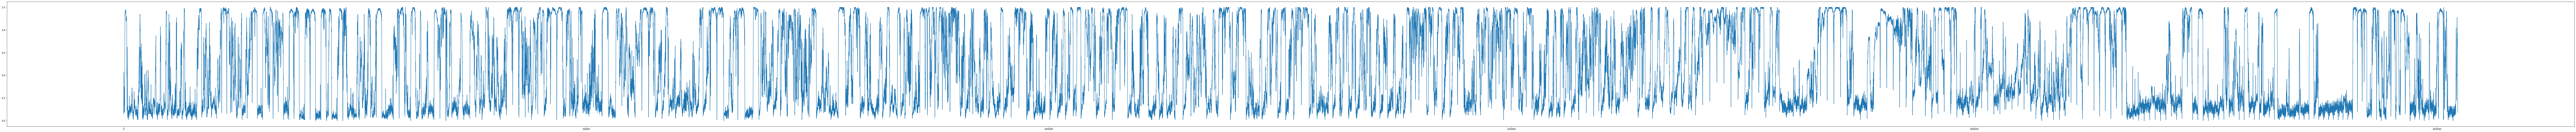

In [9]:
plt.figure(figsize = (200,10))
plt.plot(df['Total Cloud Cover [%]'].values)

In [10]:
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers):
        super(Net, self).__init__()
        self.n_hidden = n_hidden
        self.n_features = n_features
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          batch_first=True,
          bidirectional = False,
        )
        self.linear = nn.Sequential(
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,4),
        )


    def forward(self,x):
        #(batch_size, seq_length, n_features) 
        lstm_out, (h_n,c_n) = self.lstm(x) #lstm_output:(batch_size, seq_length, n_hidden) 
        #h_n/c_n : (n_layers, batch_size, n_hidden)
        #print(lstm_out.shape)
        out = self.linear((torch.mean(h_n,0).squeeze()))
        return out

model = Net(13,40,3).float().cuda()

In [12]:
valid = False
num_epochs = 20
learning_rate = 0.001
weight_decay = 0
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay,betas=[0.9,0.999])
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7,13,17,20], gamma=0.2,verbose=True)
steps = 120
mx = 120

for idx in range(len(ar)):
  ar[idx] = ar[idx].drop(['Precipitation (Accumulated) [mm]','Moisture'], 1)

for idx in range(len(testar)):
  testar[idx] = testar[idx].drop(['Precipitation (Accumulated) [mm]','Moisture'], 1)

ar[0].info()
for epoch in range(num_epochs):
  print(f'epoch:{epoch}')
  running_loss = 0
  progress = tqdm(enumerate(ar+testar if not valid else testar))
  for step,ds in progress:
      x = torch.tensor(ds.values).float().cuda()
      y30 = torch.tensor(ds['Total Cloud Cover [%]'].shift(periods = -(steps+30)).values)
      y60 = torch.tensor(ds['Total Cloud Cover [%]'].shift(periods = -(steps+60)).values)
      y90 = torch.tensor(ds['Total Cloud Cover [%]'].shift(periods = -(steps+90)).values)
      y120 = torch.tensor(ds['Total Cloud Cover [%]'].shift(periods = -(steps+120)).values)
      y = torch.stack([y30,y60,y90,y120],1).float().cuda()
      x,y = seq(x, y, steps, x.shape[0]-(mx+1+steps)) 
      #print(y.shape) 
      optimizer.zero_grad()
      o = model(x)
      loss = ((o-y)**2).mean()
      if not valid:
        loss.backward()
        optimizer.step()
      running_loss += loss.item()
      progress.set_description('Loss: {}'.format(running_loss/(step+1)))
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-03.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 467 to 985
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Global CMP22 (vent/cor) [W/m^2]        519 non-null    float64
 1   Direct sNIP [W/m^2]                    519 non-null    float64
 2   Azimuth Angle [degrees]                519 non-null    float64
 3   Tower Dry Bulb Temp [deg C]            519 non-null    float64
 4   Tower Wet Bulb Temp [deg C]            519 non-null    float64
 5   Tower Dew Point Temp [deg C]           519 non-null    float64
 6   Tower RH [%]                           519 non-null    float64
 7   Total Cloud Cover [%]                  519 non-null    float64
 8   Peak Wind Speed @ 6ft [m/s]            519 non-null    float64
 9   Avg Wind Direction @ 6ft [deg from N]  519 non-null    float64
 10  Station Pressure [mBar

Loss: 0.06858788455870386: : 666it [00:35, 18.67it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
epoch:1


Loss: 0.04821949800437627: : 666it [00:29, 22.35it/s] 


Adjusting learning rate of group 0 to 1.0000e-03.
epoch:2


Loss: 0.04637589536022742: : 666it [00:29, 22.57it/s] 


Adjusting learning rate of group 0 to 1.0000e-03.
epoch:3


Loss: 0.04515559875490927: : 666it [00:28, 23.75it/s] 


Adjusting learning rate of group 0 to 1.0000e-03.
epoch:4


Loss: 0.04422673772607633: : 666it [00:28, 23.73it/s] 


Adjusting learning rate of group 0 to 1.0000e-03.
epoch:5


Loss: 0.04354662700418478: : 666it [00:27, 24.32it/s] 


Adjusting learning rate of group 0 to 1.0000e-03.
epoch:6


Loss: 0.04284875707285879: : 666it [00:26, 24.70it/s] 


Adjusting learning rate of group 0 to 2.0000e-04.
epoch:7


Loss: 0.04048531532895719: : 666it [00:28, 23.32it/s] 


Adjusting learning rate of group 0 to 2.0000e-04.
epoch:8


Loss: 0.039721721275973516: : 666it [00:28, 23.29it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
epoch:9


Loss: 0.039385226654759665: : 666it [00:26, 25.12it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
epoch:10


Loss: 0.0391231968668279: : 666it [00:28, 23.21it/s]  


Adjusting learning rate of group 0 to 2.0000e-04.
epoch:11


Loss: 0.038889215121931234: : 666it [00:27, 24.39it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
epoch:12


Loss: 0.03865517450247642: : 666it [00:28, 23.63it/s] 


Adjusting learning rate of group 0 to 4.0000e-05.
epoch:13


Loss: 0.0380257647557956: : 666it [00:28, 23.39it/s]  


Adjusting learning rate of group 0 to 4.0000e-05.
epoch:14


Loss: 0.03778289987683973: : 666it [00:27, 23.85it/s] 


Adjusting learning rate of group 0 to 4.0000e-05.
epoch:15


Loss: 0.03769322778459679: : 666it [00:27, 23.99it/s] 


Adjusting learning rate of group 0 to 4.0000e-05.
epoch:16


Loss: 0.03761916655169883: : 666it [00:27, 24.44it/s] 


Adjusting learning rate of group 0 to 8.0000e-06.
epoch:17


Loss: 0.03743401748016714: : 666it [00:27, 23.81it/s] 


Adjusting learning rate of group 0 to 8.0000e-06.
epoch:18


Loss: 0.03739558375620929: : 666it [00:27, 23.90it/s] 


Adjusting learning rate of group 0 to 8.0000e-06.
epoch:19


Loss: 0.0373763792249028: : 666it [00:28, 23.35it/s]  

Adjusting learning rate of group 0 to 1.6000e-06.


In [13]:
x.shape[0]

114

In [15]:
testar[299].shape

(355, 13)

In [ ]:
y_hat = {30:[0]*300,60:[0]*300,90:[0]*300,120:[0]*300}
for i in range(len(testar)):
    ds = testar[i]
    x = torch.tensor(ds[-steps:].values).float().cuda()
    o = model(x.unsqueeze(0)).squeeze()*100
    y_hat[30][i] = o[0].item()
    y_hat[60][i] = o[1].item()
    y_hat[90][i] = o[2].item()
    y_hat[120][i] = o[3].item()

dsst = pd.read_csv('dataset/test.csv')
dsst['scenario_set'] = np.arange(1,301)
dsst['30_min_horizon'] = y_hat[30]
dsst['60_min_horizon'] = y_hat[60]
dsst['90_min_horizon'] = y_hat[90]
dsst['120_min_horizon'] = y_hat[120]
dsst = dsst[['scenario_set','30_min_horizon', '60_min_horizon', '90_min_horizon', '120_min_horizon']]
dsst.to_csv('dataset/test.csv',index=False)

In [ ]:
y

In [ ]:
ar